## 3. Selection and assessment of existing GSM

### Loading of the model

In [2]:
# First, we can import some functions so we can use the model
from cobra.io import read_sbml_model, write_sbml_model
from cobra import Reaction, Metabolite
from cameo.strain_design import pathway_prediction

# Second, we can read the GEM and save it as ‘model’
model = read_sbml_model('data/yeastGEM.xml')

# Thrid, we can show general information about the loaded model
model

Name,M_yeastGEM_v8__46__4__46__2
Memory address,0x026e876d72e0
Number of metabolites,2742
Number of reactions,4058
Number of groups,90
Objective expression,1.0*r_2111 - 1.0*r_2111_reverse_58b69
Compartments,"cell envelope, cytoplasm, extracellular, mitochondrion, nucleus, peroxisome, endoplasmic reticulum, Golgi, lipid particle, vacuole, endoplasmic reticulum membrane, vacuolar membrane, Golgi membrane, mitochondrial membrane"


### Model validation

# NOTE: This field is commented out as it takes ~1 hour to compute every time

%%time
!memote report snapshot data/yeastGEM.xml --filename yeastGEM.html

The file "ecYeastGEM_prot.html" is the memote analysis.
From this analysis, we can see that the total score is 16%, which is quite low. However, the tests for "Charge Balance", "Metabolite Connectivity", and a few of the reaction annotations get a score of 100%. This indicates that (Write something clever here.)

### Introduction of heterologous pathway

In [3]:
# First reaction

new_reaction1 = Reaction('R07498')  # The first of the three reactions from above

# R07498 uses:
## Zymosterol + NADPH + H+ <=> 5alpha-Cholest-8-en-3beta-ol + NADP+
## We can find these as: (Note: All of these are in the cytoplasm)
### Zymosterol = s_1569[c]
### NADPH      = s_1212[c]
### H+         = s_0794[c]
### 
### 5alpha-Cholest-8-en-3beta-ol = Not yet defined
### NADP+                        = s_1207[c]

# Since 5alpha-Cholest-8-en-3beta-ol does not exist, we will have to define it.
alphaCholest = Metabolite(id='5alpha-Cholest-8-en-3beta-ol_c', name='5alpha-Cholest-8-en-3beta-ol', compartment='c')


# We can now define the reaction stoichiometry
new_reaction1.add_metabolites({
                            model.metabolites.get_by_id("s_1569[c]"): -1,
                            model.metabolites.get_by_id("s_1212[c]"): -1,
                            model.metabolites.get_by_id("s_0794[c]"): -1,
                            alphaCholest: 1, # our newly created metabolites
                            model.metabolites.get_by_id("s_1207[c]"): 1
                             })

model.add_reactions([new_reaction1])

## Since the reaction can go both ways, we will set the bounds of the reaction to -1000 and 1000
#model.reactions.R07498.bounds = -1000, 1000

In [4]:
# Here, we are testing if the intermediate compound can be produced

with model:
    r_5a_exp = model.add_boundary(model.metabolites.get_by_id('5alpha-Cholest-8-en-3beta-ol_c'), type='demand')
    model.objective = r_5a_exp
    sol = model.optimize()
    print(sol.objective_value)

0.041224055435945456


In [5]:
# Second reaction

new_reaction2 = Reaction('R03353')  # The second of the three reactions from above

# R03353 uses:
## Lathosterol <=> 5alpha-Cholest-8-en-3beta-ol
## We can find these as: (Note: All of these are in the cytoplasm)
### 5alpha-Cholest-8-en-3beta-ol = alphaCholest
###
### Lathosterol                  = Not yet defined

# Since Lathosterol does not exist, we will have to define it.
Lathosterol = Metabolite(id='Lathosterol_c', name='Lathosterol', compartment='c')


# We can now define the reaction stoichiometry
new_reaction2.add_metabolites({
                            alphaCholest: -1, # The metabolite from above
                            Lathosterol: 1    # our newly created metabolites
                             })

model.add_reactions([new_reaction2])

## Since the reaction can go both ways, we will set the bounds of the reaction to -1000 and 1000
#model.reactions.R03353.bounds = -1000, 1000

In [6]:
# Here, we are testing if the intermediate compound can be produced

with model:
    r_la_exp = model.add_boundary(model.metabolites.get_by_id('Lathosterol_c'), type='demand')
    model.objective = r_la_exp
    sol = model.optimize()
    print(sol.objective_value)

0.04122405543594529


In [7]:
# Third reaction

new_reaction3 = Reaction('R07215')  # The third of the three reactions from above

## R07215 uses:
## Lathosterol + 2 Ferrocytochromeb5 + Oxygen + 2 H+ <=> 7-Dehydrocholesterol + 2 Ferricytochrome b5 + 2 H2O
## We can find these as: (Note: All of these are in the cytoplasm, except for the cytochromes, which are in the mitochondria)
### Lathosterol          = Lathosterol
### Ferrocytochrome b5   = s_0710[m]
### Oxygen               = s_1275[c]
### H+                   = s_0794[c]
###
### 7-Dehydrocholesterol = Not yet defined
### Ferricytochrome b5   = s_0709[m]
### H2O                  = s_0803[c]



# Since 7-Dehydrocholesterol does not exist, we will have to define it.
Dehydrocholesterol = Metabolite(id='7-Dehydrocholesterol_c', name='7-Dehydrocholesterol', compartment='c')


new_reaction3.add_metabolites({
                            Lathosterol: -1, # The metabolite we created above
                            model.metabolites.get_by_id("s_0710[m]"): -2,
                            model.metabolites.get_by_id("s_1275[c]"): -1,
                            model.metabolites.get_by_id("s_0794[c]"): -2,
                            Dehydrocholesterol: 1, # our newly created metabolites
                            model.metabolites.get_by_id("s_0709[m]"): 2,
                            model.metabolites.get_by_id("s_0803[c]"): 2
                             })

model.add_reactions([new_reaction3])

## Since the reaction can go both ways, we will set the bounds of the reaction to -1000 and 1000
#model.reactions.R07215.bounds = -1000, 1000

In [8]:
r_7DH_export = model.add_boundary(model.metabolites.get_by_id('7-Dehydrocholesterol_c'), type='demand')

with model:
    model.objective = r_7DH_export
    sol = model.optimize()
    print(sol.objective_value)

0.041173424848048555


From this, we can see that we are now able to produce 7-dehydrocholesterol in our cell factory!

The current state of the model is saved as "yeastGEM_het.xml" in the data folder.

In [9]:
write_sbml_model(model, "data/yeastGEM_het.xml")

## 4. Computer-Aided Cell Factory Engineering

### Initial analysis

Now that we have our metablic model with a functional pathway, we can investigate its behavior and experiment with optimization routes.

First, we will look at the trade-off with growth.

In [10]:
from cobra.flux_analysis.phenotype_phase_plane import production_envelope, add_envelope
import pandas as pd
import matplotlib

In [11]:
ppp_7DH = production_envelope(model,
                    reactions=[model.reactions.R07215],
                    objective=model.reactions.r_2111)

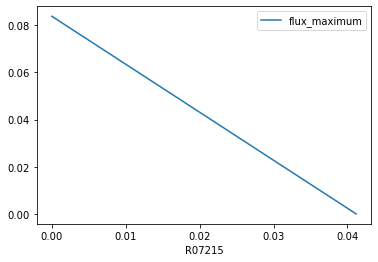

In [12]:
pppp = ppp_7DH.plot(x='R07215', y='flux_maximum')
fig = pppp.get_figure()
fig.savefig("figures/initial_ppp")

Note: For some reason, the code below is enourmously slow. It should take ~1 hour, but it has run for 2-3 hours and no output was produced.

In [ ]:
%%time

essential = []
non_essential = []

for reaction in model.reactions:
    with model:
        reaction.knock_out()
        if model.slim_optimize(error_value=0.) == 0.0:
            essential.append(reaction)
        else:
            non_essential.append(reaction)

In [ ]:
print(essential)

In [ ]:
len(essential)

In [33]:
essential[1]

Reaction identifier,r_0104
Name,acetyl-CoA C-acetyltransferase
Memory address,0x020791f108b0
Stoichiometry,2.0 s_0376[m] <=> s_0370[m] + s_0532[m] 2.0 acetyl-CoA [mitochondrion] <=> acetoacetyl-CoA [mitochondrion] + coenzyme A [mitochondrion]
GPR,YPL028W
Lower bound,-1000.0
Upper bound,1000.0


In [37]:
non_essential = []

with model:
    for reaction in model.reactions:
        reaction.knock_out()
        if model.slim_optimize(error_value=0.) != 0.0:
            non_essential.append(reaction)

In [38]:
len(non_essential)

20

In [39]:
non_essential

[<Reaction r_0001 at 0x20791e87070>,
 <Reaction r_0002 at 0x20791e9c0a0>,
 <Reaction r_0003 at 0x20791e9c850>,
 <Reaction r_0004 at 0x20791e9cc70>,
 <Reaction r_0005 at 0x20791e9c340>,
 <Reaction r_0006 at 0x20791e9c940>,
 <Reaction r_0007 at 0x20791e9c280>,
 <Reaction r_0012 at 0x20791e9c6d0>,
 <Reaction r_0013 at 0x20791e9c370>,
 <Reaction r_0014 at 0x20791eaed60>,
 <Reaction r_0015 at 0x20791eaeee0>,
 <Reaction r_0016 at 0x20791e9cb20>,
 <Reaction r_0017 at 0x20791e9cf40>,
 <Reaction r_0018 at 0x20791e9cf10>,
 <Reaction r_0019 at 0x20791eb5f10>,
 <Reaction r_0020 at 0x20791eaee50>,
 <Reaction r_0021 at 0x20791eaef10>,
 <Reaction r_0022 at 0x20791e9c8b0>,
 <Reaction r_0023 at 0x20791ebfdc0>,
 <Reaction r_0024 at 0x20791eb5b80>]

In [40]:
non_essential[1]

Reaction identifier,r_0002
Name,(R)-lactate:ferricytochrome-c 2-oxidoreductase
Memory address,0x020791e9c0a0
Stoichiometry,s_0027[m] + 2.0 s_0709[m] --> 2.0 s_0710[m] + s_1401[m] (R)-lactate [mitochondrion] + 2.0 ferricytochrome c [mitochondrion] --> 2.0 ferrocytochrome c [mitochondrion] + pyruvate [mitochondrion]
GPR,( YDL178W and YEL039C ) or ( YDL178W and YJR048W )
Lower bound,0.0
Upper bound,1000.0


In [35]:
len(model.reactions)

4062

In [ ]:
with model
    for reaction in non_essential

From this graph, we can see that there is a direct trade-off between growth and 7-dehydrocholesterol production. This means that an evolution strategy for optimization by growth-coupled production is outside of our grasp without further engineering.

Instead, we will try to do some knock-outs to improve the system.

In [69]:
single = {}
growth = {}
for reaction in model.reactions:
    with model:
        model.objective = r_7DH_export
        reaction.bounds = 0,0
        solution = model.optimize()
        single[reaction] = solution.objective_value
        growth[reaction] = solution.fluxes.to_dict().get("r_2111")

cobra/util/solver.py:416 UserWarning: solver status is 'infeasible'


In [76]:
for reaction in growth:
    print(value)

NameError: name 'value' is not defined

In [82]:
for key, value in growth.items():
    print(value)

-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0


In [72]:
growth

{<Reaction r_0001 at 0x7f63af0baac8>: -0.0,
 <Reaction r_0002 at 0x7f63af0be160>: -0.0,
 <Reaction r_0003 at 0x7f63af0be748>: -0.0,
 <Reaction r_0004 at 0x7f63af0bec18>: -0.0,
 <Reaction r_0005 at 0x7f63af0c0198>: -0.0,
 <Reaction r_0006 at 0x7f63af0c05f8>: -0.0,
 <Reaction r_0007 at 0x7f63af0c0b38>: -0.0,
 <Reaction r_0012 at 0x7f63af0c0eb8>: -0.0,
 <Reaction r_0013 at 0x7f63af0bc550>: -0.0,
 <Reaction r_0014 at 0x7f63af0bcb00>: -0.0,
 <Reaction r_0015 at 0x7f63af0c20f0>: -0.0,
 <Reaction r_0016 at 0x7f63af0c2630>: -0.0,
 <Reaction r_0017 at 0x7f63af0c2ba8>: -0.0,
 <Reaction r_0018 at 0x7f63af0c3160>: -0.0,
 <Reaction r_0019 at 0x7f63af0c36a0>: -0.0,
 <Reaction r_0020 at 0x7f63af0c3be0>: -0.0,
 <Reaction r_0021 at 0x7f63af0c5160>: -0.0,
 <Reaction r_0022 at 0x7f63af0c5630>: -0.0,
 <Reaction r_0023 at 0x7f63af0c5cf8>: -0.0,
 <Reaction r_0024 at 0x7f63af0c62b0>: -0.0,
 <Reaction r_0025 at 0x7f63af0c6940>: -0.0,
 <Reaction r_0026 at 0x7f63af0c6f28>: -0.0,
 <Reaction r_0027 at 0x7f63af0ca

In [70]:
solution

,fluxes,reduced_costs
r_0001,0.00,0.0
r_0002,0.00,0.0
r_0003,-0.35,0.0
r_0004,0.00,0.0
r_0005,0.00,0.0
...,...,...
r_4699,-0.00,0.0
R07498,0.00,0.0
R03353,0.00,0.0
R07215,0.00,0.0


In [12]:
from cameo import phenotypic_phase_plane

In [13]:
r_7DH_export

Reaction identifier,DM_7-Dehydrocholesterol_c
Name,7-Dehydrocholesterol demand
Memory address,0x02079f3abdc0
Stoichiometry,7-Dehydrocholesterol_c --> 7-Dehydrocholesterol -->
GPR,
Lower bound,0
Upper bound,1000.0


In [14]:
ppp = phenotypic_phase_plane(model,
                             variables=[model.reactions.get_by_id("r_2111")],
                             objective=model.reactions.get_by_id("R07215"))

ppp.plot()

TypeError: plot() missing 1 required positional argument: 'plotter'

In [14]:
from cameo.strain_design.deterministic.flux_variability_based import FSEOF

In [15]:
fseof = FSEOF(model)

In [16]:
fseof.run(target=model.reactions.R07215)

,1,2,3,4,5,6,7,8,9,10
r_0006,0.020945,0.020945,0.020945,0.020945,0.020945,0.020945,0.020945,0.020945,0.020945,0.020945
r_0007,0.006378,0.006378,0.006378,0.006378,0.006378,0.006378,0.006378,0.006378,0.006378,0.006378
r_0013,0.000016,0.000016,0.000016,0.000016,0.000016,0.000016,0.000016,0.000016,0.000016,0.000016
r_0014,0.000084,0.000084,0.000084,0.000084,0.000084,0.000084,0.000084,0.000084,0.000084,0.000084
r_0015,0.000084,0.000084,0.000084,0.000084,0.000084,0.000084,0.000084,0.000084,0.000084,0.000084
...,...,...,...,...,...,...,...,...,...,...
r_4590,0.000229,0.000229,0.000229,0.000229,0.000229,0.000229,0.000229,0.000229,0.000229,0.000229
r_4591,0.000063,0.000063,0.000063,0.000063,0.000063,0.000063,0.000063,0.000063,0.000063,0.000063
r_4598,0.083748,0.083748,0.083748,0.083748,0.083748,0.083748,0.083748,0.083748,0.083748,0.083748
r_4599,0.083748,0.083748,0.083748,0.083748,0.083748,0.083748,0.083748,0.083748,0.083748,0.083748


In [17]:
from cameo.flux_analysis.analysis import phenotypic_phase_plane
from cameo.strain_design.deterministic import DifferentialFVA

In [18]:
production = phenotypic_phase_plane(model,
                                             variables=[model.reactions.get_by_id("r_2111")],
                                             objective=model.metabolites.get_by_id("7-Dehydrocholesterol_c"))
production.plot(height=400)

TypeError: plot() missing 1 required positional argument: 'plotter'